In [1]:
import sys
import os
import subprocess
import tarfile
import shutil

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle

import boda
from boda.generator.parameters import StraightThroughParameters
from boda.generator import FastSeqProp, AdaLead
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm
from boda.model.mpra_basset import MPRA_Basset
from boda.common import constants, utils
from boda.generator.energy import BaseEnergy

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

In [2]:
#----------------------- Artisanal model -----------------------
# ! gsutil cp gs://syrgoth/checkpoints/manual_checkpoint_multioutput_lasthidden250_L1_ReLU6_sneak2_double1_ACGT_gtex_noNorm_lessVal_activity_1_4.ckpt ./

artisan_model = MPRA_Basset(extra_hidden_size = 250,
                            last_activation='ReLU6')
checkpoint = torch.load('manual_checkpoint_multioutput_lasthidden250_L1_ReLU6_sneak2_double1_ACGT_gtex_noNorm_lessVal_activity_1_4.ckpt')
artisan_model.load_state_dict(checkpoint['state_dict'])
artisan_model.eval()
print('')

In [3]:
left_flank = boda.common.utils.dna2tensor(constants.MPRA_UPSTREAM[-200:]).unsqueeze(0)
right_flank = boda.common.utils.dna2tensor(constants.MPRA_DOWNSTREAM[:200] ).unsqueeze(0)

In [4]:
class BaseEnergy(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.model = None
        
    def forward(self, x_in):
        hook = self.energy_calc(x_in)       
        try:
            pen = self.penalty(x_in)
            hook = hook + pen
        except NotImplementedError:
            pass       
        return hook
      
    def energy_calc(self, x):
        raise NotImplementedError("Energy caclulation not implemented.")
        x_in = x.to(self.model.device)       
        hook = self.model(x_in)
        # do math
        return hook
      
    def penalty(self, x):
        raise NotImplementedError("Penalty not implemented")        
        hook = x        
        return hook

    
    
class EntropyEnergy(BaseEnergy):
    def __init__(self, model, bias_cell=None, bias_alpha=1.):
        super().__init__()
        
        self.model = model
        self.model.eval()
        
        self.bias_cell = bias_cell
        self.bias_alpha= bias_alpha
        
    def forward(self, x):
        hook   = x#.to(self.model.device)        
        hook   = self.model(hook)
        energy = boda.graph.utils.shannon_entropy(hook)     
        if self.bias_cell is not None:
            energy = energy - hook[...,self.bias_cell].mul(self.bias_alpha)        
        return energy.mean()
 

    
class OverMaxEnergy(BaseEnergy):
    def __init__(self, model, bias_cell=0, bias_alpha=1., score_pct=.3, bending_factor=1.0):
        super().__init__()
        
        self.model = model
        self.model.eval()
        
        self.bias_cell = bias_cell
        self.bias_alpha= bias_alpha
        self.score_pct = score_pct
        self.bending_factor = bending_factor
        
    def energy_calc(self, x):
        hook = x#.to(self.model.device)
        
        hook = self.bend(self.model(hook))
#         energy = hook[...,[ x for x in range(hook.shape[-1]) if x != self.bias_cell]].max(-1).values \
#                  - hook[...,self.bias_cell].mul(self.bias_alpha)
        energy = self.over_max_diff(hook)
        energy = self.reduction(energy)
        return energy
    
    def over_max_diff(self, hook):
        diff = hook[...,[ x for x in range(hook.shape[-1]) if x != self.bias_cell]].max(-1).values \
                 - hook[...,self.bias_cell].mul(self.bias_alpha)
        return diff
    
    def bend(self, x):
        return x - self.bending_factor * (torch.exp(-x) - 1)
    
    def reduction(self, x):
        return x.mean()
    
    def penalty(self, x):
        return self.motif_penalty(x)

    def register_penalty(self, x):
        try:
            self.penalty_filters = x.type_as(self.penalty_filters)
        except AttributeError:
            self.register_buffer('penalty_filters', x)
            
    def register_threshold(self, x):
        try:
            self.score_thresholds = x.type_as(self.score_thresholds)
        except AttributeError:
            self.register_buffer('score_thresholds', x)
            
    def streme_penalty(self, streme_output):
        
        try:
            penalty_weight = (self.penalty_filters.shape[0] // 2) + 1
        except AttributeError:
            penalty_weight = 1
        
        motif_data = parse_streme_output(streme_output['output'])
        top_ppm    = common.utils.align_to_alphabet( 
            motif_data['motif_results'][0]['ppm'], 
            motif_data['meta_data']['alphabet'], 
            common.constants.STANDARD_NT 
        )
        top_ppm = torch.tensor(top_ppm).float()
        background = [ motif_data['meta_data']['frequencies'][nt] 
                       for nt in common.constants.STANDARD_NT ]
        top_pwm = ppm_to_pwm(top_ppm, background) * (penalty_weight**0.33) # (4, L)
        max_score = torch.max(top_pwm, dim=0)[0].sum()
        top_pwm_rc = common.utils.reverse_complement_onehot(top_pwm) # (4, L)

        proposed_penalty = torch.stack([top_pwm, top_pwm_rc] ,dim=0) # (2, 4, L)
        proposed_thresholds = torch.tensor(2 * [self.score_pct * max_score]) # (2,)
        
        try:
            penalty_filters = torch.cat(
                [self.penalty_filters, proposed_penalty.to(self.penalty_filters.device)], 
                dim=0
            ) # (2k+2, 4, L)
            score_thresholds= torch.cat(
                [self.score_thresholds, proposed_thresholds.to(self.score_thresholds.device)]
            ) # (2k+2,)
            
        except AttributeError:
            penalty_filters = proposed_penalty.to(self.model.device)
            score_thresholds= proposed_thresholds.to(self.model.device)
            
        self.register_penalty(penalty_filters)
        self.register_threshold(score_thresholds)
                
    def motif_penalty(self, x):
        try:
            motif_scores = F.conv1d(x, self.penalty_filters)
            score_thresholds = torch.ones_like(motif_scores) * self.score_thresholds[None, :, None]
            mask = torch.ge(motif_scores, score_thresholds)
            #masked_scores = torch.masked_select(motif_scores, mask)
            masked_scores = motif_scores * mask.float()
            return masked_scores.flatten(1).sum(dim=-1).div((self.penalty_filters.shape[0] // 2) * x.shape[0])

        except AttributeError:
            return 0    

In [5]:
#-------------------------- Settings --------------------------
model = artisan_model
bias_cell = 2
bending_factor = 1.0

batch_size  = 50 
n_samples  = 20    
num_steps  = 300   
score_pct = 0.0

affine_trans = False
scheduler    = True
loss_plots   = False

#-------------------------- Energy --------------------------
energy_test = OverMaxEnergy(model=model, bias_cell=bias_cell, bending_factor=bending_factor)

#-------------------------- Parameters --------------------------
theta_ini = torch.randn(batch_size, 4, 200)
params = StraightThroughParameters(data=theta_ini,
                                   left_flank=left_flank,
                                   right_flank=right_flank,
                                   n_samples=n_samples,
                                   affine=affine_trans)

#-------------------------- Generator --------------------------
generator = FastSeqProp(energy_fn=energy_test,
                        params=params)
generator.cuda()
generator.run(steps=num_steps,
              learning_rate=0.5,
              step_print=5,
              lr_scheduler=scheduler,
              create_plot=loss_plots)

Steps:   0%|          | 0/300 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
Steps: 100%|██████████| 300/300 [00:30<00:00,  9.85it/s, Loss=-3.79, LR=1e-6]    


In [31]:
#-------------------------- Generate sequences --------------------------
samples = params()
preds = energy_test.model(samples)

sequence_samples = samples.detach().cpu().unflatten(0, (n_samples, batch_size))
predictions = preds.detach().cpu().unflatten(0, (n_samples, batch_size))
entropies = boda.graph.utils.shannon_entropy(preds).detach().cpu().unflatten(0, (n_samples, batch_size))#

entropy_tensor = entropies
prediction_tensor = predictions
sequences_tensor = sequence_samples
    
best_entropy_idxs = torch.argmin(entropy_tensor, dim=0)
#best_entropy_idxs = torch.argmin(preds[:,:2].max(dim=1).values.unflatten(0, (n_samples, batch_size)), dim=0)
best_entropies = []
best_predictions = []
best_sequences = []
for idx, best_idx in enumerate(best_entropy_idxs.tolist()):
    best_entropies.append(entropy_tensor[best_idx, idx])
    best_predictions.append(prediction_tensor[best_idx, idx, :])
    best_sequences.append(sequences_tensor[best_idx, idx, :, 200:400])

best_sequences = torch.stack(best_sequences, dim=0)
best_entropies = torch.tensor(best_entropies)
best_predictions = torch.stack(best_predictions, dim=0)

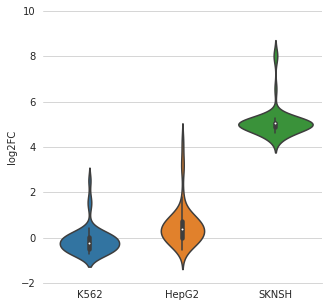

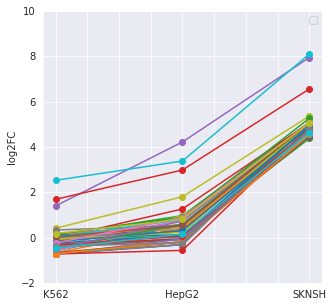

In [32]:
#-------------------------- Plot activities --------------------------
prediction_df = pd.DataFrame(best_predictions.numpy(), columns=['K562', 'HepG2', "SKNSH"])

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(5,5))
    sns.violinplot(data=prediction_df)
    sns.despine(left=True)
    plt.ylabel('log2FC')
    plt.ylim(-2,10)
    plt.show()

with sns.axes_style("darkgrid"):
    prediction_df.T.plot(figsize=(5,5), style='-o')
    plt.ylim(-2,10)
    plt.legend('')
    plt.ylabel('log2FC')
    plt.show()

In [28]:
torch.argmin(preds[:,:2].max(dim=1).values.unflatten(0, (n_samples, batch_size)), dim=0)

tensor([-0.6881, -0.6615, -0.7297, -0.3856, -0.7297, -0.6612, -0.5799, -0.7297,
        -0.3085, -0.7297, -0.7297, -0.4948, -0.4788, -0.6552, -0.7009, -0.2749,
        -0.6615, -0.7297, -0.1443, -0.6408, -0.2018, -0.7189, -0.5366, -0.7297,
         2.2491, -0.5173, -0.6781, -0.7292, -0.4670,  0.3869, -0.3735, -0.4782,
        -0.6315, -0.0752, -0.6460, -0.3477, -0.6158, -0.3017, -0.3959, -0.5774,
        -0.7066, -0.7297, -0.2948, -0.7297, -0.5725, -0.7297, -0.7297, -0.4768,
        -0.5010, -0.4650], device='cuda:0', grad_fn=<MinBackward0>)